# Group 4


## Problem Statement
Given this huge dataset of many various indicators, we would like to use machine learning, to be used on these indicators, that any regular adult can obtain by going through a health screening - to evaluate the risk any given individual has for heart disease.

### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
1. [Data cleaning](#1)
    - [test](#1.1)
2. [Exploratory Data Analysis](#2)
    - [Visualisation](#2.1)
    - [Selecting best features](#2.2)
3. [Data Preparation](#3)
4. [Modeling](#4)
5. [Fine tuning](#5)

### Import the dataset

In [158]:
import pandas as pd
import numpy as np
import seaborn as sb
import imblearn
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import Counter
from sklearn.datasets import make_classification
from pandas.api.types import is_string_dtype
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from scipy.stats import chi2 as chi_2

sb.set()

In [159]:
df = pd.read_csv('data/heart_2022_no_nans.csv')
# Preliminary check of the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

From the above, we can see that there is a lot of categorical data. A few numerical data, like Height and Weight

***

<h1 align="center"><font color='Blue'>Data Cleaning</font></h1>

- We would like to first check if the data is clean. We can first check if there exists any rows that has nulls in them.

In [160]:
print(df.isnull().values.any())

False


<div class="alert alert-block alert-warning">  
<b>Observation:</b> This tells us that there are no null values in any of the rows in the dataset. This is good. Next, we want to check if there are any odd values in the dataset. We can do this by looking and eyeballing.
</div>

In [161]:
for column in df:
    if is_string_dtype(df[column]):
        print(column, df[column].unique())

State ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Guam' 'Puerto Rico'
 'Virgin Islands']
Sex ['Female' 'Male']
GeneralHealth ['Very good' 'Fair' 'Good' 'Excellent' 'Poor']
LastCheckupTime ['Within past year (anytime less than 12 months ago)'
 '5 or more years ago'
 'Within past 2 years (1 year but less than 2 years ago)'
 'Within past 5 years (2 years but less than 5 years ago)']
PhysicalActivities ['Yes' 'No']
RemovedTeeth ['None of t



<div class="alert alert-block alert-info">
<b>Plan:</b> We want to check for categorical data, as we will not be able to look for any "odd" values for numerical values until we do some form of analysis. Most of the columns look fine, but there are some weird ones

- HadDiabetes (Yes, but only during pregnancy (female))
- HadDiabetes (No, pre-diabetes or borderline diabetes)
- ECigaretteUsage (Not at all (right now))
- CovidPos (Tested positive using home test without a health professional)

We want to check if these values are significant. If they are not a significant portion of the dataset, looking at these features specifically would not give us any new insights.
</div>

In [162]:
print("Had Diabetes : Yes, but only during pregnancy (female) : ", len(df.loc[df['HadDiabetes'] == 'Yes, but only during pregnancy (female)']) / len(df))
print("Had Diabetes : No, pre-diabetes or borderline diabetes : ", len(df.loc[df['HadDiabetes'] == 'No, pre-diabetes or borderline diabetes']) / len(df))
print("ECigaretteUsage : Not at all (right now) : ", len(df.loc[df['ECigaretteUsage'] == 'Not at all (right now)']) / len(df))
print("CovidPos : Tested positive using home test without a health professional: ", len(df.loc[df['CovidPos'] == 'Tested positive using home test without a health professional']) / len(df))

Had Diabetes : Yes, but only during pregnancy (female) :  0.008060254773963304
Had Diabetes : No, pre-diabetes or borderline diabetes :  0.021916739153409043
ECigaretteUsage : Not at all (right now) :  0.17592329141296306
CovidPos : Tested positive using home test without a health professional:  0.034110770581492714


<div class="alert alert-block alert-warning">  
<b>Observation:</b> We can see that both options for <b>diabetes</b> is definitely not significant. <b>CovidPos</b> is also not significant as well. The option for <b>ECigarette</b> Usage is very significant, almost 1/5 of the dataset. We will keep that one in.
</div>

In [163]:
df['HadDiabetes'] = df['HadDiabetes'].replace('Yes, but only during pregnancy (female)', 'Yes')
df['HadDiabetes'] = df['HadDiabetes'].replace('No, pre-diabetes or borderline diabetes', 'No')
df['CovidPos'] = df['CovidPos'].replace('Tested positive using home test without a health professional', 'Yes')

Check that the replacements are correct.

In [164]:
print(df['HadDiabetes'].unique())
print(df['CovidPos'].unique())

['No' 'Yes']
['No' 'Yes']


In [165]:
df.head(5)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No




<div class="alert alert-block alert-info">  
<b>Plan:</b> Since the response column is the 'HadHeartAttack' column, we want to check if there is sufficient in the dataset.
</div>

In [166]:
print(df['HadHeartAttack'].value_counts())

HadHeartAttack
No     232587
Yes     13435
Name: count, dtype: int64


<div class="alert alert-block alert-warning">  
<b>Observation:</b> 
We notice that there is a significant class imbalance for <b>HadHeartAttack</b> here. For every ~24 rows, there will be one Yes. If we used the dataset as it is, then it will be significantly skewed towards 'No'. There will be poor performance on the minority class ('Yes') in this case. 

To fix this, we would downsample the amount of 'No's to the amount of 'Yes's, so that there is an equal amount. We would prefer to not do the alternative, to upsample the 'Yes', should be done with caution as is the nature of the dataset here (medical).

We also observe that there is sufficient rows of 'Yes's that we can use, even after we downsample (13k rows each is sufficient). We will have ~26k rows to work with and we bleieve that will be enough for this.
</div>

In [167]:
# Downsample to column 
def down_sample(df, column):
    counts = df[column].value_counts()
    df = pd.concat([df[df[column] == value].sample(n=min(counts)) for value in counts.index])
    return df

def down_sample2(x, y):
    under = RandomUnderSampler()
    x, y = under.fit_resample(x, y)
    return x, y

def over_sample(x, y):
    over = RandomOverSampler()
    x, y = over.fit_resample(x, y)
    return x, y

def over_sample_smote(x, y):
    over = SMOTE()
    x, y = over.fit_resample(x, y)
    return x, y

def df_split(df):
    x = pd.DataFrame(df.drop(['HadHeartAttack'], axis=1))
    y = pd.DataFrame(df['HadHeartAttack'])
    return x, y

def shuffle_train_test_split(df, test_size=0.2):
    x = pd.DataFrame(df.drop(['HadHeartAttack'], axis=1))
    y = pd.DataFrame(df['HadHeartAttack'])
    return train_test_split(x, y, test_size)

def concat_x_y(x, y):
    return pd.concat([x, y], axis=1)

# df = down_sample(df, 'HadHeartAttack')
x, y = df_split(df)
x, y = over_sample(x, y)
df = concat_x_y(x, y)

In [168]:
# TODO : why do we need this?
df.reset_index(inplace=True, drop=True)
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadAngina,...,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HadHeartAttack
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,No
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,No
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No


Note that `.sample` in pandas will randomly sample. So there will not be any bias in the sampling technique here.

<h1 align="center"><font color='Blue'>Data exploration</font></h1>

Given so many variables, the immediate task is to find out which variables are the most meaningful and contribute to the final response (HadHeartAttack). We want to sieve out what's useful and what's not.

In [169]:
numeric = df.select_dtypes(include = ['int', 'float'])
categorical = df.select_dtypes(include = ['object'])

numeric.set_index(df.index)
numeric['HadHeartAttack'] = df['HadHeartAttack']
numeric.head()

#print("Number of numeric columns: ", len(numeric.columns))
#print("Number of categorical columns: ", len(categorical.columns))

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI,HadHeartAttack
0,4.0,0.0,9.0,1.60,71.67,27.99,No
1,0.0,0.0,6.0,1.78,95.25,30.13,No
2,0.0,0.0,8.0,1.85,108.86,31.66,No
3,5.0,0.0,9.0,1.70,90.72,31.32,No
4,3.0,15.0,5.0,1.55,79.38,33.07,No


<h3 align="center"><font color='Green'>Numerical Data Analysis</font></h3>

 We first begin with numerical data analysis


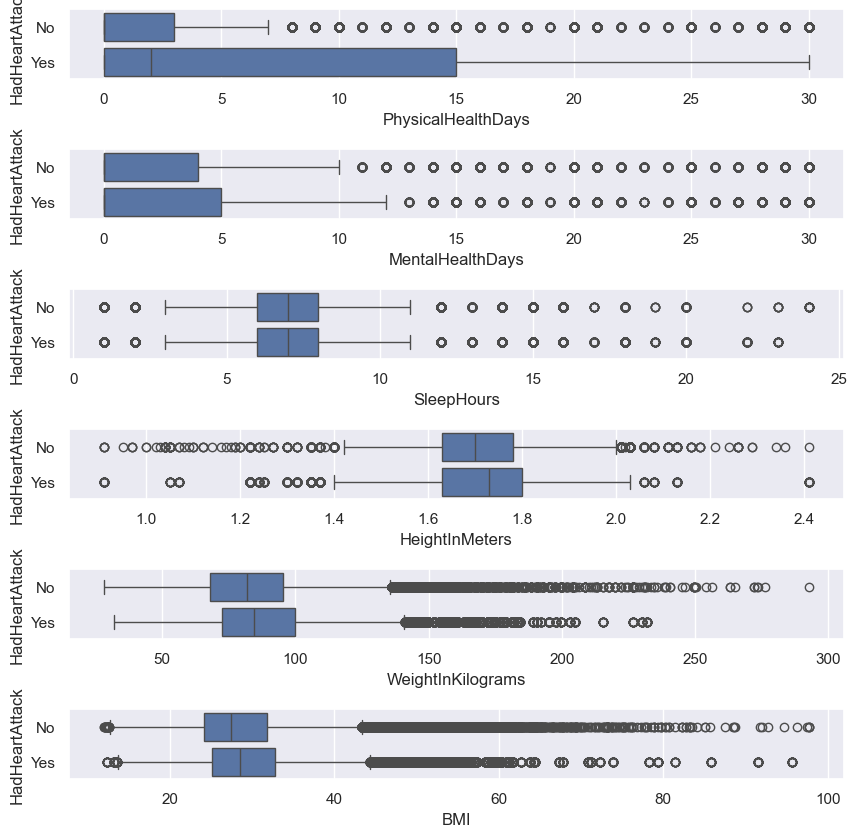

In [170]:
# Draw the distributions of all variables
f, axes = plt.subplots(6, 1, figsize=(10, 10), gridspec_kw={'hspace': 1})
f.subplots_adjust(hspace=0.3, wspace=0.3)

numerical_columns = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI' ]
for i, column in enumerate(numerical_columns):
    sb.boxplot(data = numeric, y='HadHeartAttack', x=column, orient = "h", ax = axes[i], showfliers = True)

<div class="alert alert-block alert-warning">
<b>Observation:</b> From the distribution of numeric data in this dataset, there is no noticeable partiiton to help classification with the exeception of <b>PhysicalHealthDays</b>.We can consider dropping <b>BMI, WeightInKilograms, HeightInMeters, MentalHealthDays</b>
</div>

<h3 align="center"><font color='green'>Categorical Data Analysis</font></h3>

We want to check see which categorical variables are best at predicting if a person has some form of heart disease.

In [171]:
# We don't want to include the HadHeartAttack column here as we want to compare against it.
categorical_columns = [col for col in df if is_string_dtype(df[col]) 
                       and col != 'HadHeartAttack'
                       and col != 'State'
                       and col != 'AgeCategory'
                       and col != 'RaceEthnicityCategory']
print(len(categorical_columns), categorical_columns)

30 ['Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']


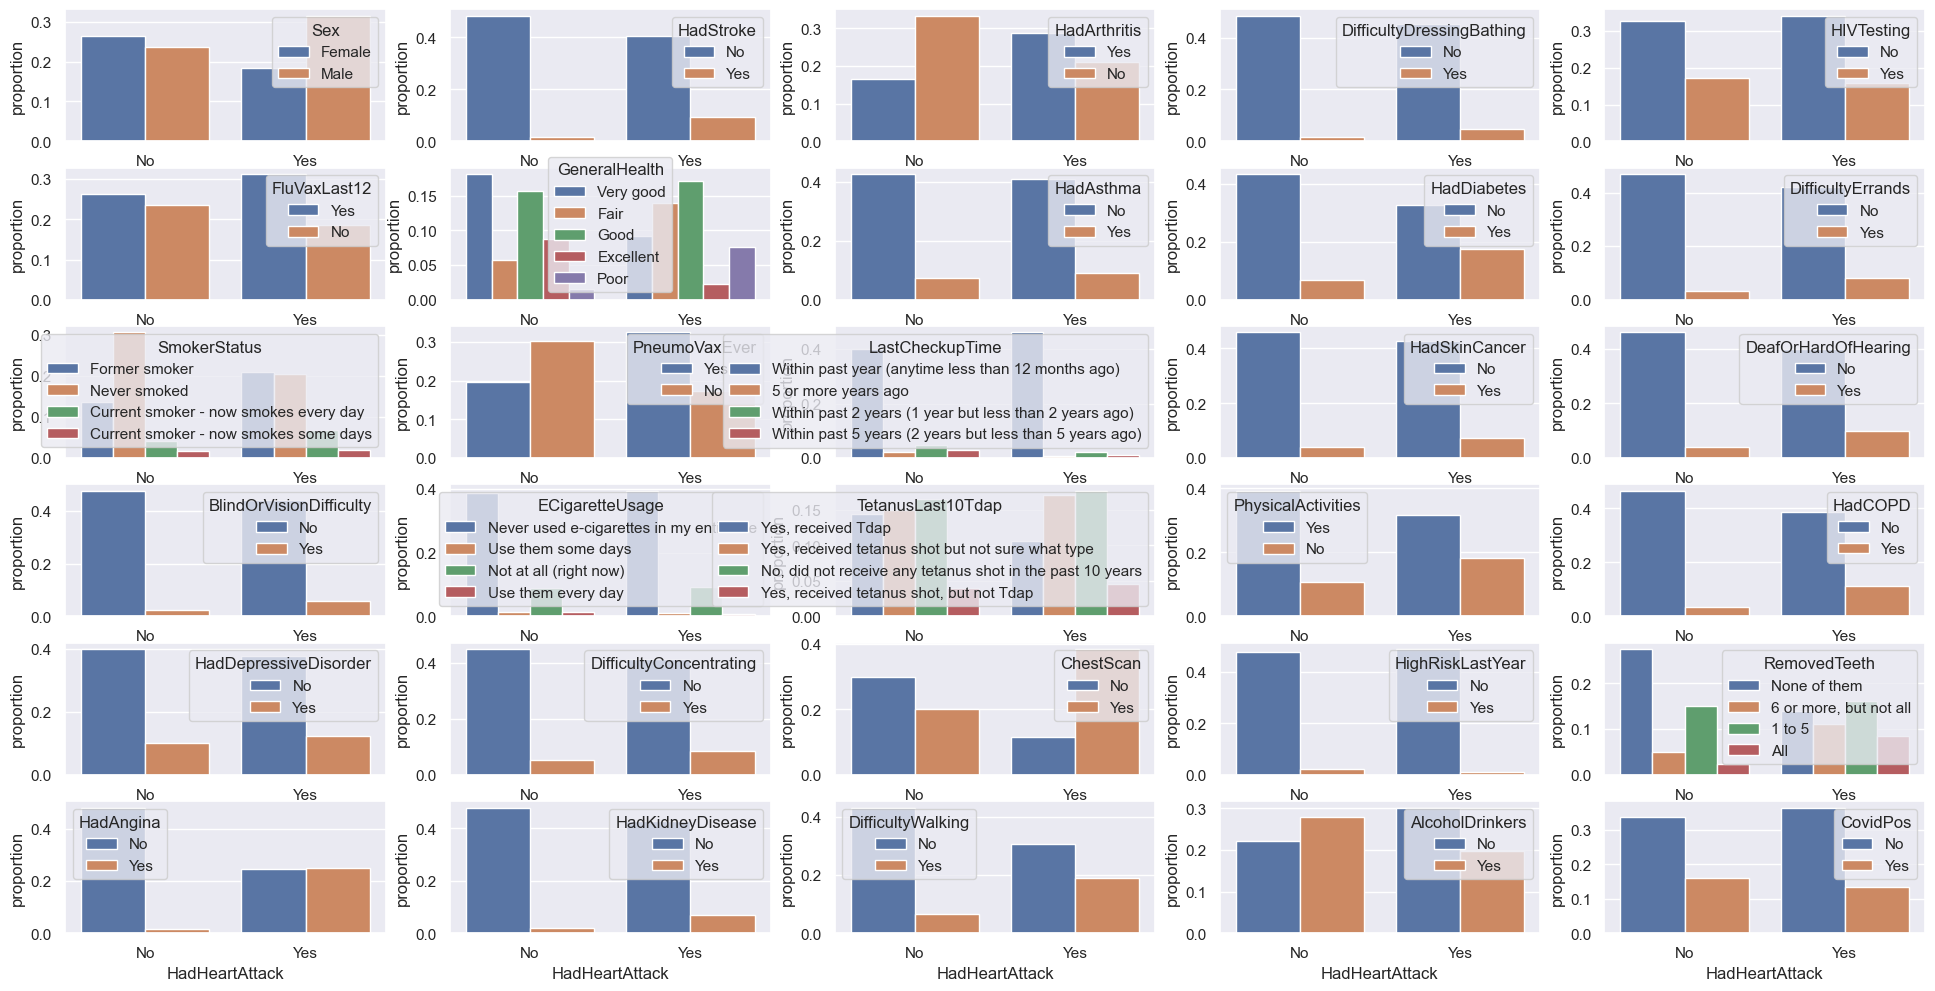

In [172]:
# 30 columns, so lets build 6x5 grid
f, axes = plt.subplots(6, 5, figsize=(24, 12))
for i, col in enumerate(categorical_columns):
    r = int(i % 6)
    c = int(i % 5)
    sb.countplot(pd.concat([df[col], df['HadHeartAttack']], axis=1),
                 x='HadHeartAttack', hue=col, stat='proportion',
                 legend='auto', ax=axes[r][c])

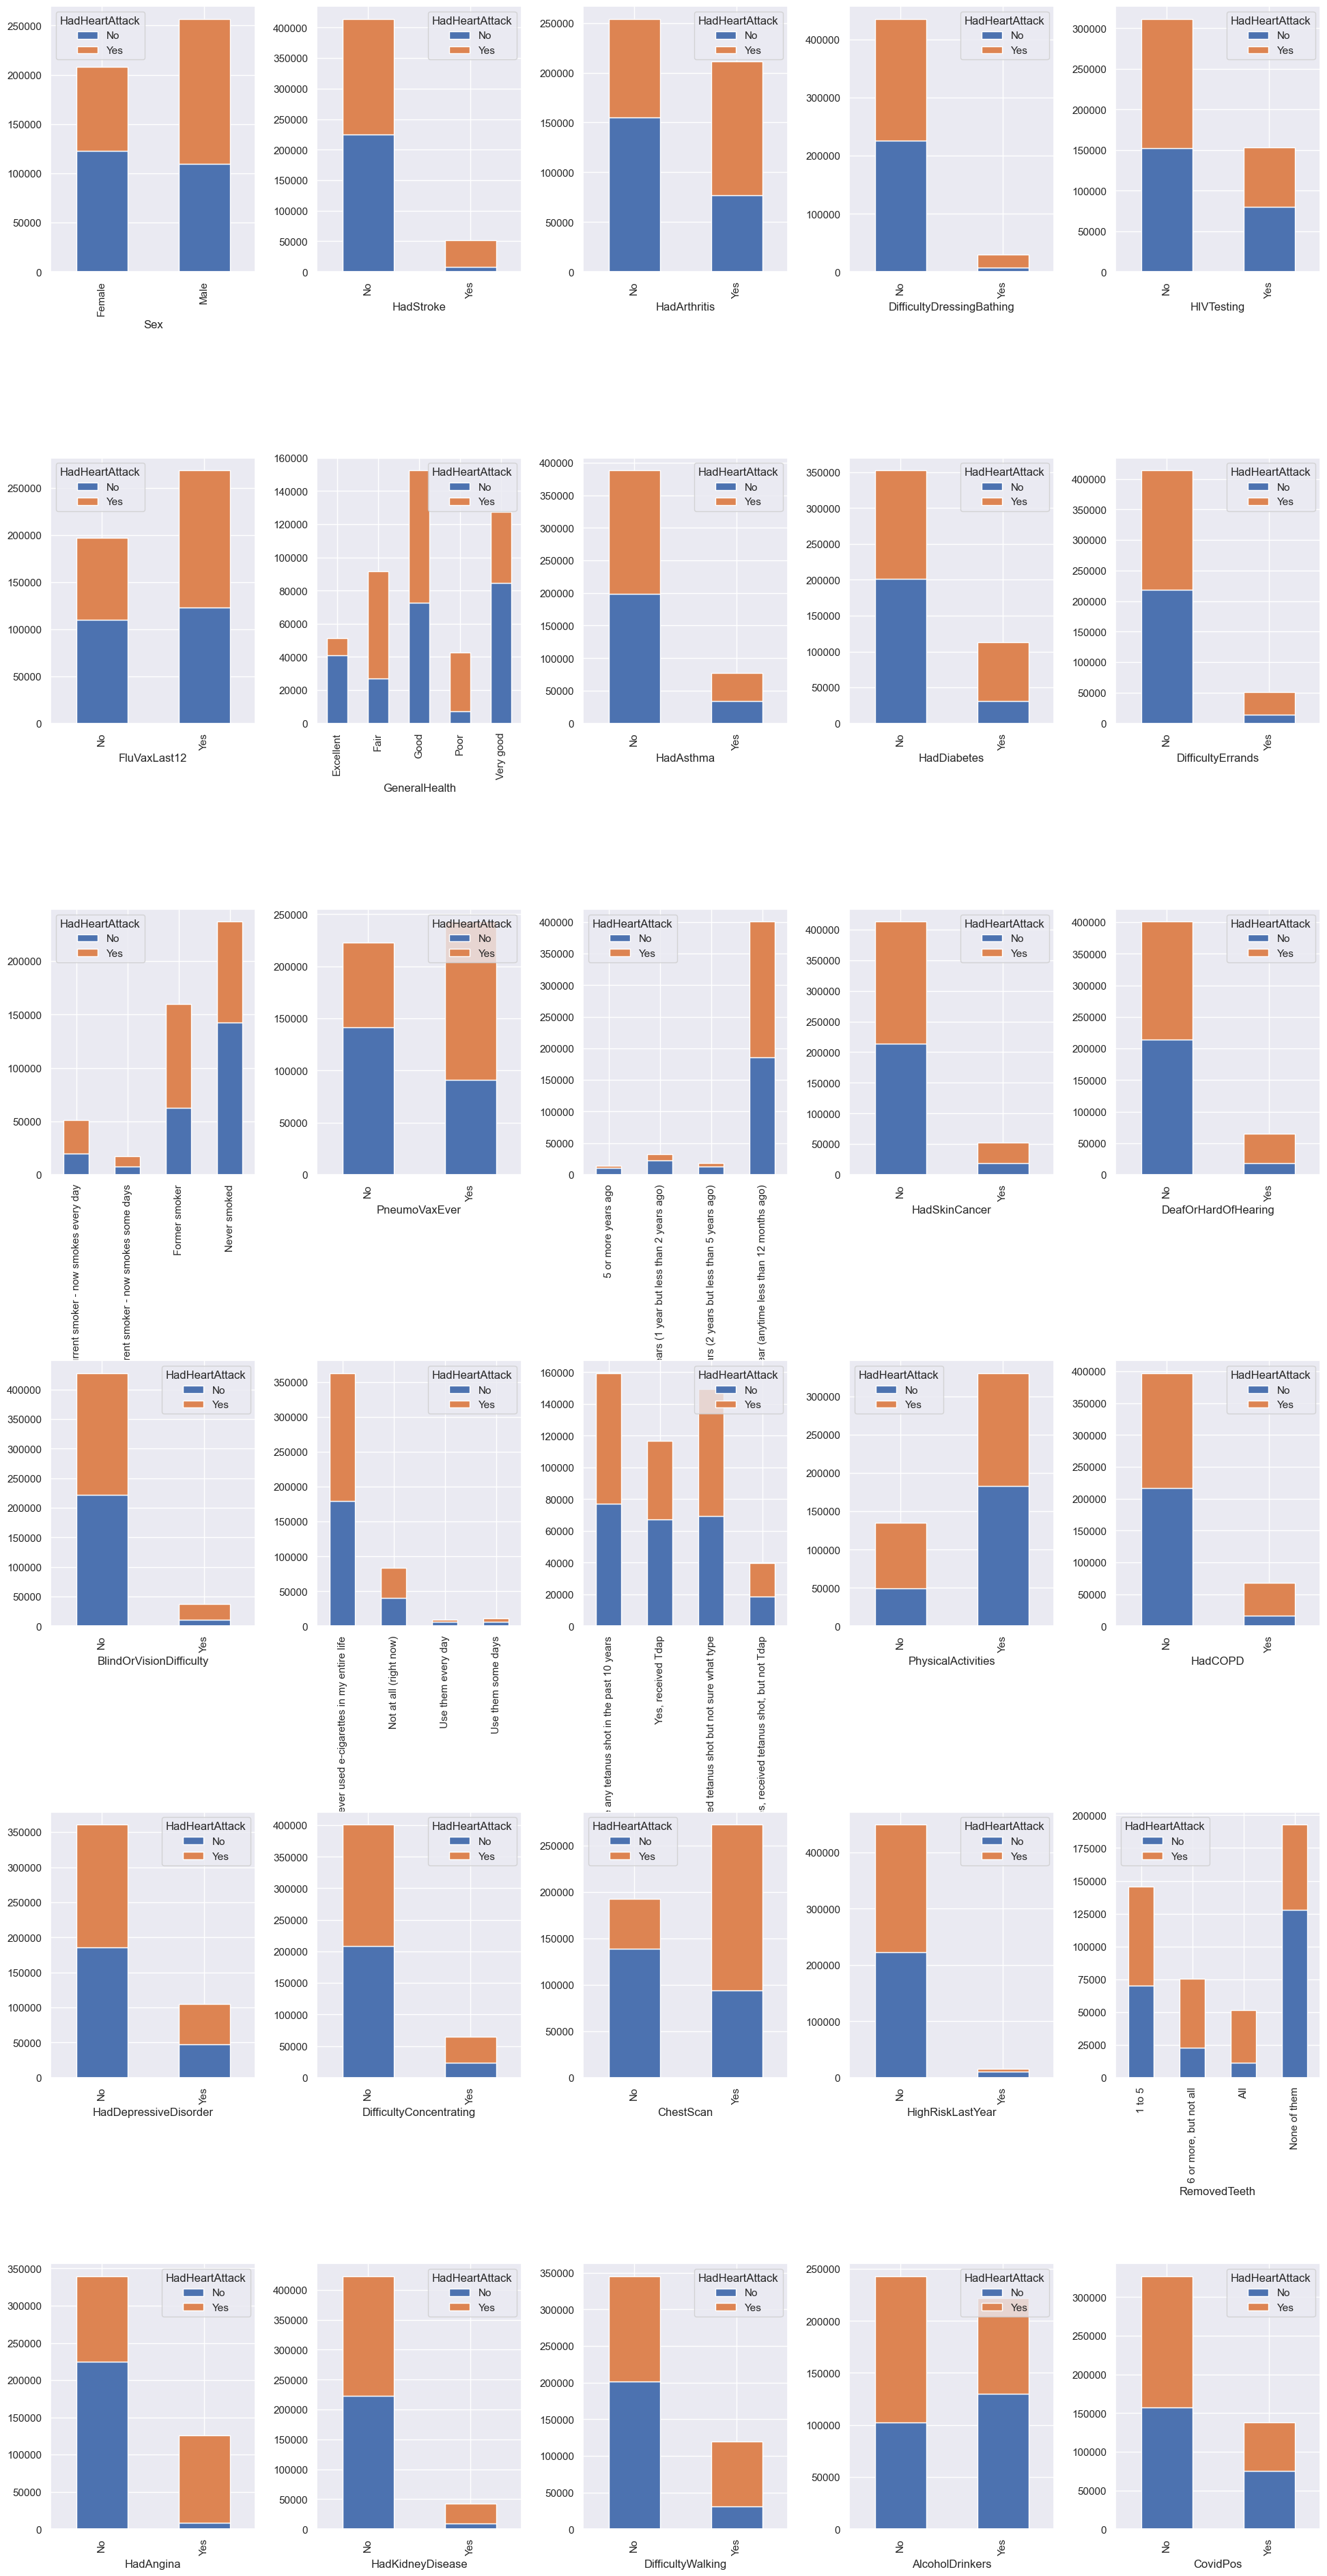

In [173]:
f, axes = plt.subplots(6, 5, figsize=(24, 48))
f.subplots_adjust(hspace=0.7, wspace=0.3)

for i, col in enumerate(categorical_columns):
    r = int(i % 6)
    c = int(i % 5)
    result= df.groupby(col)['HadHeartAttack'].value_counts().unstack()
    result.plot(kind='bar', stacked=True, ax=axes[r][c])

<div class="alert alert-block alert-warning">
    <b>Observation:</b> Based on obeservation alone, we can see some correlation between <b>HadStroke, DifficultyDressingBathing, HadAngina.</b> We will keep these variables in mind.
</div>

## Prepare the data

We have a few goals in this section. We want to prepare the dataset such that it is best suited for the computer to read (i.e. numbers, not strings).

1. For columns which are boolean (True/False), we want to encode them as 1/0
2. For categorical columns which have a **relationship**  between the categorical outcomes, that naturally encode as a hierarchy, $a < b < c$, we want to use ordinal encoding for them
3. For categorical columns which **do not** have any relationships between each other, we want to one-hot encode them.

In [174]:
# Label Encode
def encode_df(df):
    # df_encode = df.copy()
    for column in df.columns:
        if (len(df[column].value_counts()) == 2):
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
        # print(column)
    
    # Ordinal encoding
    df['GeneralHealth'].replace({'Poor': 0,'Fair': 1,'Good': 2,'Very good': 3,'Excellent': 4}, inplace=True)
    df['SmokerStatus'].replace({'Never smoked': 0,'Former smoker': 1,'Current smoker - now smokes some days': 2,'Current smoker - now smokes every day': 3}, inplace=True)
    df['AgeCategory'].replace({'Age 18 to 24': 0,'Age 25 to 29': 1, 'Age 30 to 34': 2,'Age 35 to 39': 3,'Age 40 to 44': 4,'Age 45 to 49': 5,'Age 50 to 54': 6,'Age 55 to 59': 7,'Age 60 to 64': 8,'Age 65 to 69': 9,'Age 70 to 74': 10,'Age 75 to 79': 11,'Age 80 or older': 12}, inplace=True)
    df['ECigaretteUsage'].replace({'Never used e-cigarettes in my entire life': 0,'Not at all (right now)': 1,'Use them some days': 2,'Use them every day': 3}, inplace=True)
    df['TetanusLast10Tdap'].replace({'Yes, received Tdap': 0, 'Yes, received tetanus shot but not sure what type': 1, 'No, did not receive any tetanus shot in the past 10 years': 2, 'Yes, received tetanus shot, but not Tdap': 3}, inplace=True)
    
    # One hot encoded
    df = pd.get_dummies(df)
    return df

# We don't want two separate yes/no columns for this
# df['HadHeartAttack'] = df['HadHeartAttack'].replace({'Yes': 1, 'No': 0})

df_encode = encode_df(df)
x = pd.DataFrame(df_encode.drop(['HadHeartAttack'], axis=1))
y = pd.DataFrame(df_encode['HadHeartAttack'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

/var/folders/1h/n71pkykd6q509yz2cyyfsngr0000gn/T/ipykernel_49232/1353827018.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['GeneralHealth'].replace({'Poor': 0,'Fair': 1,'Good': 2,'Very good': 3,'Excellent': 4}, inplace=True)
/var/folders/1h/n71pkykd6q509yz2cyyfsngr0000gn/T/ipykernel_49232/1353827018.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavio

In [175]:
for col in x.columns:
    print(col + ':',x[col].unique())

Sex: [0 1]
GeneralHealth: [3 1 2 4 0]
PhysicalHealthDays: [ 4.  0.  5.  3.  2. 25. 30. 15. 29.  8. 16. 20. 10.  9.  7.  1. 21.  6.
 27. 14. 12. 11. 13. 28. 17. 23. 24. 26. 18. 22. 19.]
MentalHealthDays: [ 0. 15.  4. 25.  5. 30. 27.  3.  2.  1. 10. 20. 21.  6.  7.  8. 14.  9.
 12. 18. 29. 28. 17. 11. 16. 13. 26. 22. 24. 19. 23.]
PhysicalActivities: [1 0]
SleepHours: [ 9.  6.  8.  5.  7. 10.  4. 12.  3. 18. 11.  2.  1. 16. 14. 15. 13. 20.
 24. 23. 19. 17. 22.]
HadAngina: [0 1]
HadStroke: [0 1]
HadAsthma: [0 1]
HadSkinCancer: [0 1]
HadCOPD: [0 1]
HadDepressiveDisorder: [0 1]
HadKidneyDisease: [0 1]
HadArthritis: [1 0]
HadDiabetes: [0 1]
DeafOrHardOfHearing: [0 1]
BlindOrVisionDifficulty: [0 1]
DifficultyConcentrating: [0 1]
DifficultyWalking: [0 1]
DifficultyDressingBathing: [0 1]
DifficultyErrands: [0 1]
SmokerStatus: [1 0 3 2]
ECigaretteUsage: [0 2 1 3]
ChestScan: [0 1]
AgeCategory: [ 9 10 11 12  6  4  8  7  5  3  1  2  0]
HeightInMeters: [1.6  1.78 1.85 1.7  1.55 1.63 1.75 1.68 1.83 1.

## Feature selection

Given that this dataset has a lot of columns, we want to do some feature selection. We have visualized from above, while some categories are promising, it is still rather difficult to eyeball. Here, we want to feature select the top $n$ columns, (TODO - justify why $n$), and we can cross-validate to check if those columns are the important features.

TODO - justify which classifier we use `chi2`, `mutual_info_classif`, `f_classif`

# Chi Square Test

In [176]:
n_features = 5
selector = SelectKBest(chi2, k=n_features)
x_new = selector.fit_transform(x, y)

# Print out the top columns
mask = selector.get_support()
important_features = []
# Loop over the same columns that we train on
for b, val in zip(mask, x.columns):
    if b:
        important_features.append(val)

print(important_features)

['GeneralHealth', 'PhysicalHealthDays', 'HadAngina', 'DifficultyWalking', 'AgeCategory']


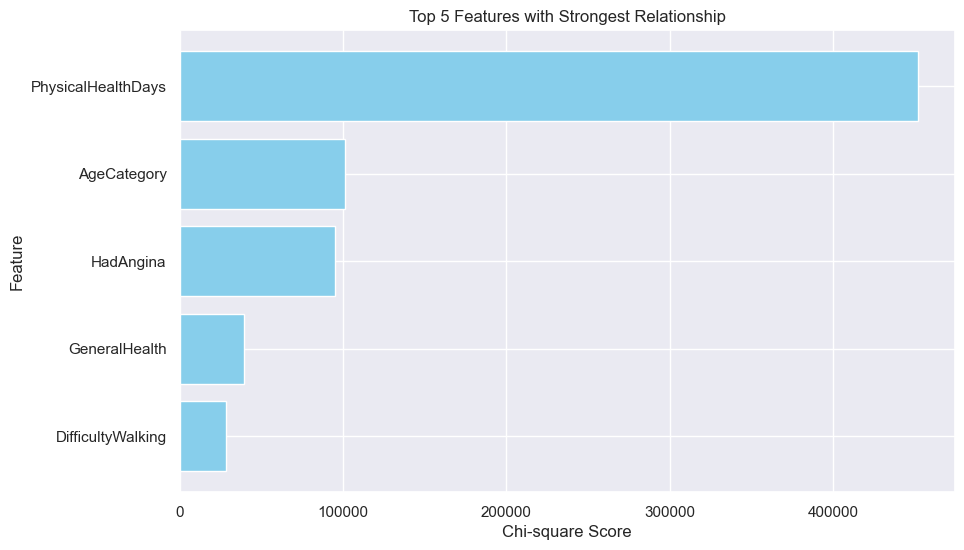

In [177]:
chi2_scores = selector.scores_
feature_names = x.columns
sorted_indices = np.argsort(chi2_scores)[::-1]  # Reverse order to get highest scores first
top_n_indices = sorted_indices[:n_features]
top_n_scores = chi2_scores[top_n_indices]
top_n_features = [feature_names[i] for i in top_n_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(np.arange(n_features), top_n_scores, color='skyblue')
plt.yticks(np.arange(n_features), top_n_features)
plt.title('Top {} Features with Strongest Relationship'.format(n_features))
plt.xlabel('Chi-square Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
plt.show()

Given these important features that we have singled out, let's plot their graphs again to make sure that these are actually important features. With fewer of these columns, we should be able to see it's effect on the graph.

TODO - Pick one of the visualizations / find another one that shows this better

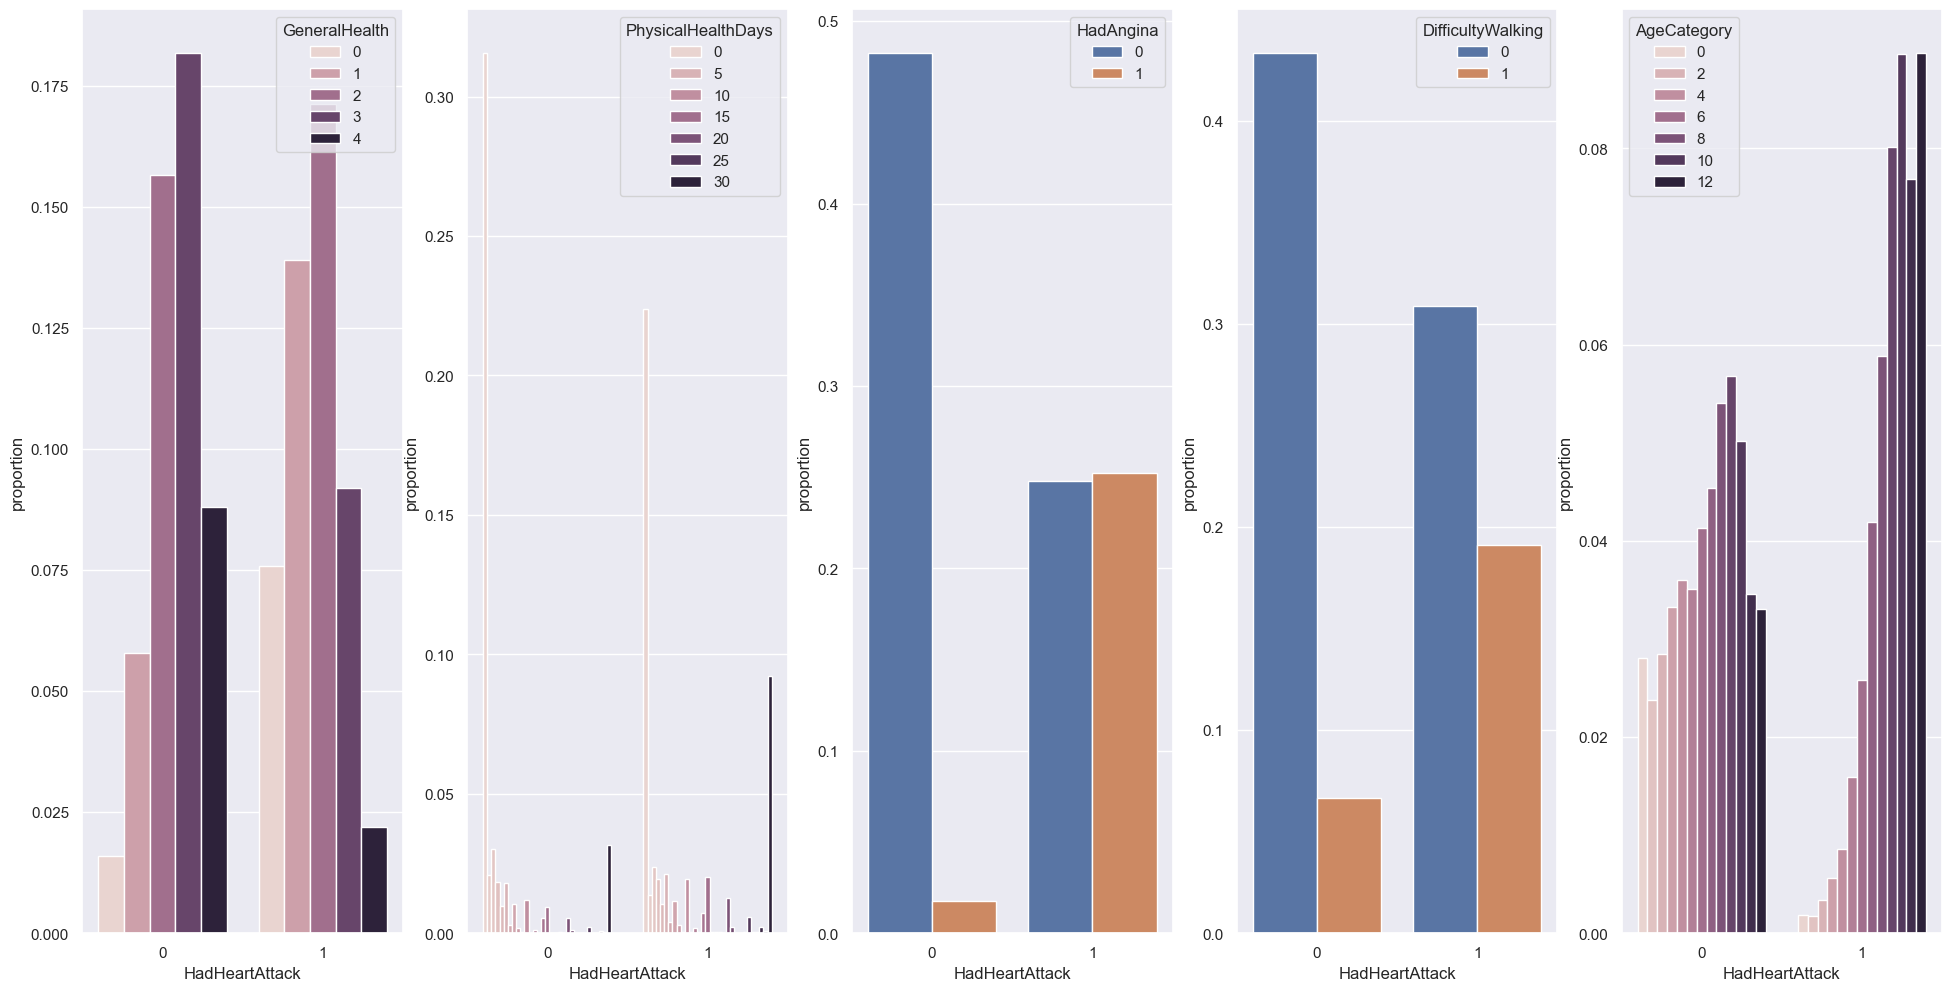

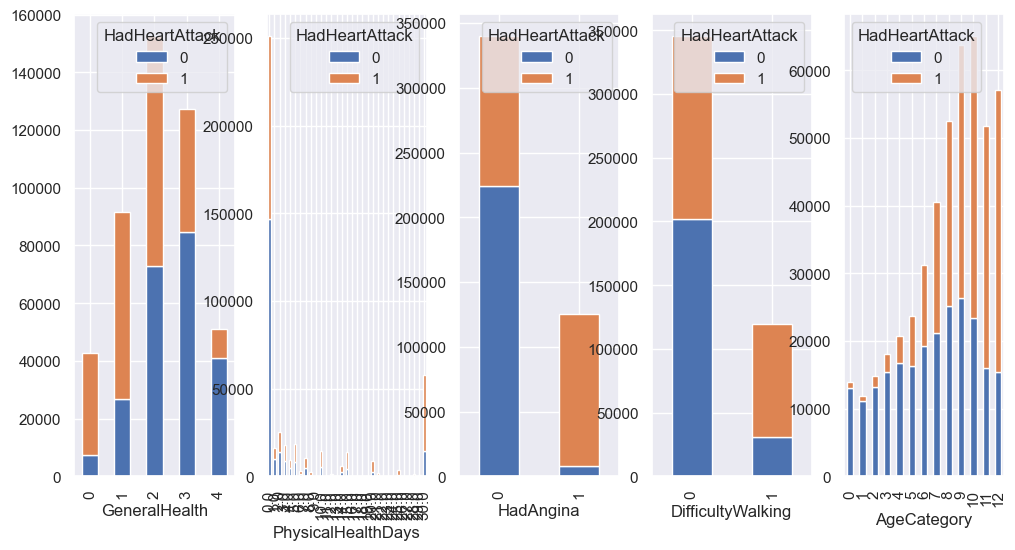

In [178]:
f, axes = plt.subplots(1, n_features, figsize=(24, 12))
for i, col in enumerate(important_features):
    sb.countplot(pd.concat([df_encode[col], df['HadHeartAttack']], axis=1),
                 x='HadHeartAttack', hue=col, stat='proportion',
                 legend='auto', ax=axes[i])

f, axes = plt.subplots(1, n_features, figsize=(12, 6))
for i, col in enumerate(important_features):
    result= df_encode.groupby(col)['HadHeartAttack'].value_counts().unstack()
    result.plot(kind='bar', stacked=True, ax=axes[i])

(TODO - There has to be a better way to visualize some of these)


From this we can clearly tell that these features are the most important. For instance, The higher one's age category is, the higher the likelihood of osmeone having a heart attack.

Now we will only use these features for our training from now on.

(TODO - drop the rest if the above is clear and makes sense?)

In [187]:
# Drop the all except these columns
df = df[important_features + ['HadHeartAttack']]

<h1 align="center"><font color='Blue'>Modeling</font></h1>

Firstly without dropping any columns and performing any sort of analysis to determine importance of features

In [188]:
# We want to use the data that is shuffled outside
# Don't mix shuffling of data into training the model
# All models should share the same set of shuffled data, and if the shuffled
# data should be changed, then we can reuse it again
def train_model(x_train, x_test, y_train, y_test, model, cv=None):
    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    score = cross_val_score(model, x,y, cv=cv)
    
    print("Train accuracy : ", model.score(x_train, y_train))
    print("Train MSE: ", mean_squared_error(y_train, y_train_pred), '\n')
    
    print("Test accuracy : ", model.score(x_test, y_test))
    print("Test MSE: ", mean_squared_error(y_test, y_test_pred), '\n')

    print("Number of folds: ", cv)
    print("Accuracy score (Cross Validated):", score.mean())
    print("Standard Deviation (Cross Validated): ", ( score.std()), '\n')
    
    # Print the Accuracy Measures from the Confusion Matrix
    cmTrain = confusion_matrix(y_train, y_train_pred)
    tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
    fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
    tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
    fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)
    
    print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
    print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
    print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
    print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)), '\n')
    
    cmTest = confusion_matrix(y_test, y_test_pred)
    tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
    fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
    tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
    fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)
    
    print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
    print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
    print("FPR Test :\t", (fpTest/(tnTest + fpTest)))
    print("FNR Test :\t", (fnTest/(tpTest + fnTest)))
    

    f,axes = plt.subplots(1,2, figsize=(24,8))
    f.subplots_adjust(hspace=0.5, wspace=0.5)

    # Plot the two-way Confusion Matrix
    sb.heatmap(confusion_matrix(y_train, y_train_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0])
    axes[0].set_title('Confusion Matrix: Train Data', fontweight='bold', size =20)
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1])
    axes[1].set_title('Confusion Matrix: Test Data', fontweight = 'bold', size = 20)

# Decision Tree Model

**Reasons for using this model:**

- Able to handle both numerical and categorical data
- Able to handle non linear relationships
- Able to show feature imporatance
- Robust to outliers

[Text(0.5, 0.875, 'HadAngina <= 0.5\ngini = 0.5\nsamples = 372139\nvalue = [186142, 185997]'),
 Text(0.25, 0.625, 'ChestScan <= 0.5\ngini = 0.449\nsamples = 271948\nvalue = [179585, 92363]'),
 Text(0.125, 0.375, 'AgeCategory <= 7.5\ngini = 0.305\nsamples = 134662\nvalue = [109431, 25231]'),
 Text(0.0625, 0.125, 'gini = 0.165\nsamples = 76292\nvalue = [69376, 6916]'),
 Text(0.1875, 0.125, 'gini = 0.431\nsamples = 58370\nvalue = [40055, 18315]'),
 Text(0.375, 0.375, 'HadStroke <= 0.5\ngini = 0.5\nsamples = 137286\nvalue = [70154, 67132]'),
 Text(0.3125, 0.125, 'gini = 0.495\nsamples = 120843\nvalue = [66479, 54364]'),
 Text(0.4375, 0.125, 'gini = 0.347\nsamples = 16443\nvalue = [3675, 12768]'),
 Text(0.75, 0.625, 'Sex <= 0.5\ngini = 0.122\nsamples = 100191\nvalue = [6557, 93634]'),
 Text(0.625, 0.375, 'GeneralHealth <= 1.5\ngini = 0.159\nsamples = 33377\nvalue = [2908, 30469]'),
 Text(0.5625, 0.125, 'gini = 0.127\nsamples = 19309\nvalue = [1316, 17993]'),
 Text(0.6875, 0.125, 'gini = 0.2

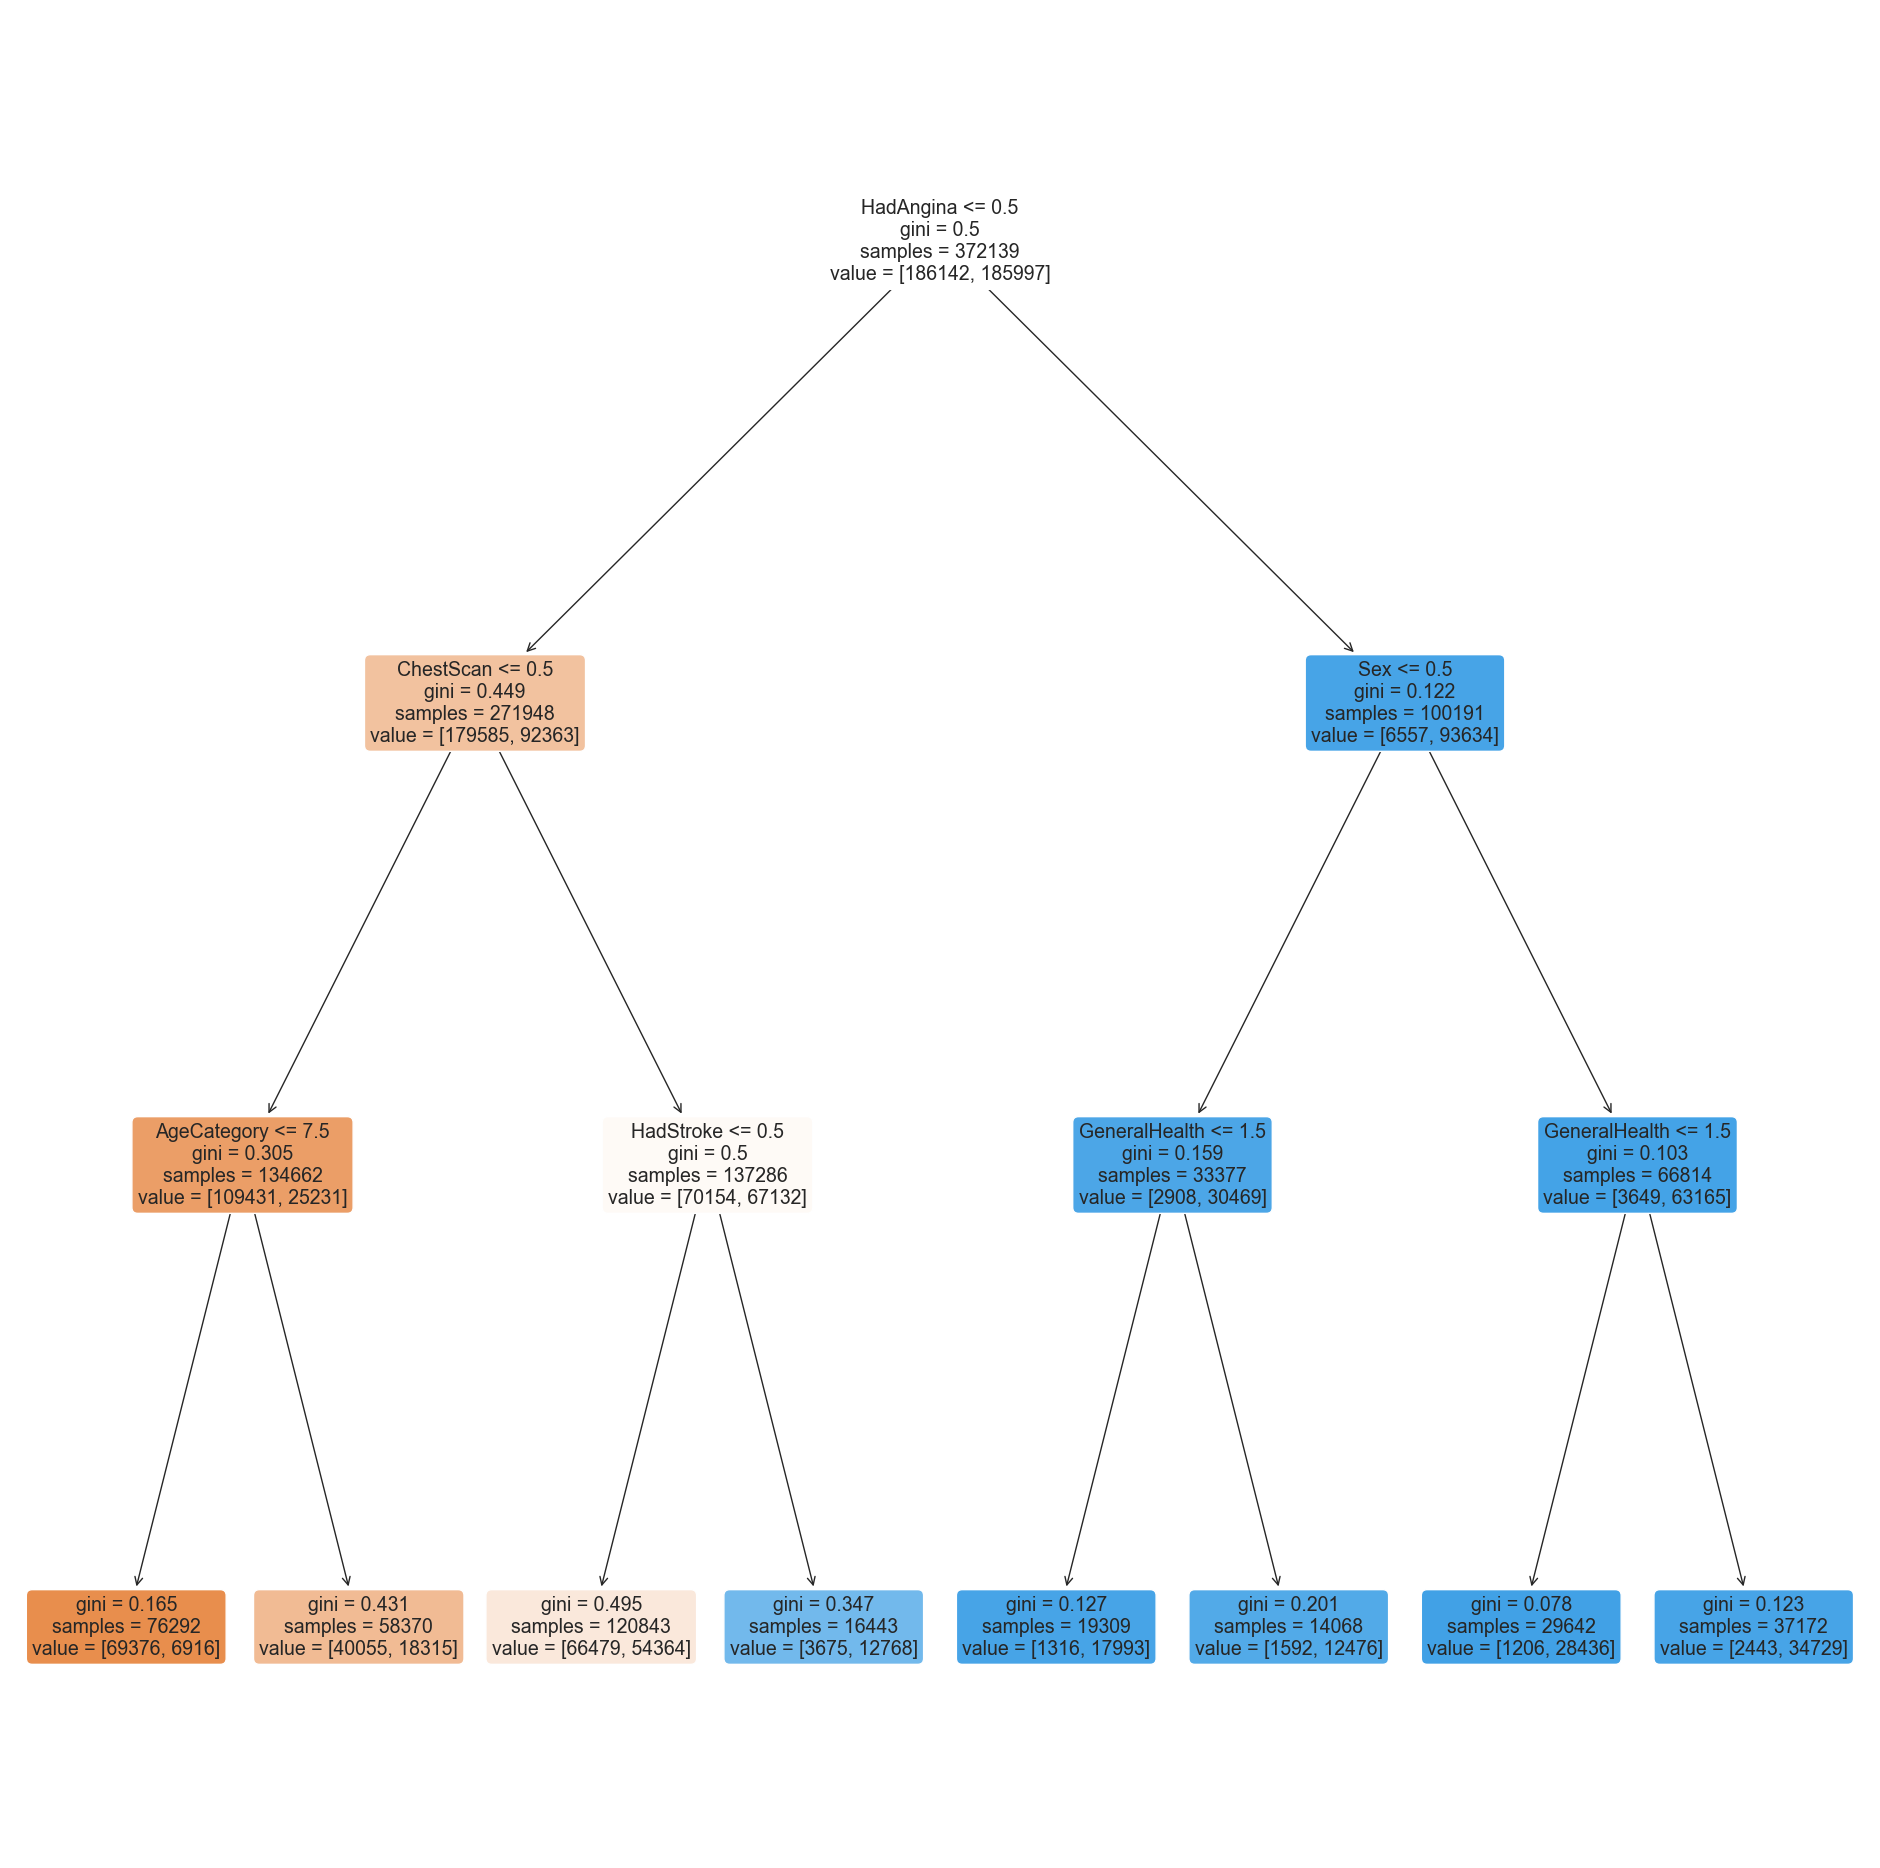

In [189]:
dectree = DecisionTreeClassifier(max_depth = 3)  # change max_depth to experiment
dectree.fit(x_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=x_train.columns.tolist())

Train accuracy :  0.786018127635104
Train MSE:  0.2139818723648959 

Test accuracy :  0.7881120008598914
Test MSE:  0.21188799914010856 

Number of folds:  5
Accuracy score (Cross Validated): 0.7491991387651253
Standard Deviation (Cross Validated):  0.026007558487504395 

TPR Train :	 0.7943568982295414
TNR Train :	 0.7776858527360833
FPR Train :	 0.2223141472639168
FNR Train :	 0.20564310177045866 

TPR Test :	 0.7984760678257137
TNR Test :	 0.7777155775648616
FPR Test :	 0.22228442243513832
FNR Test :	 0.20152393217428632


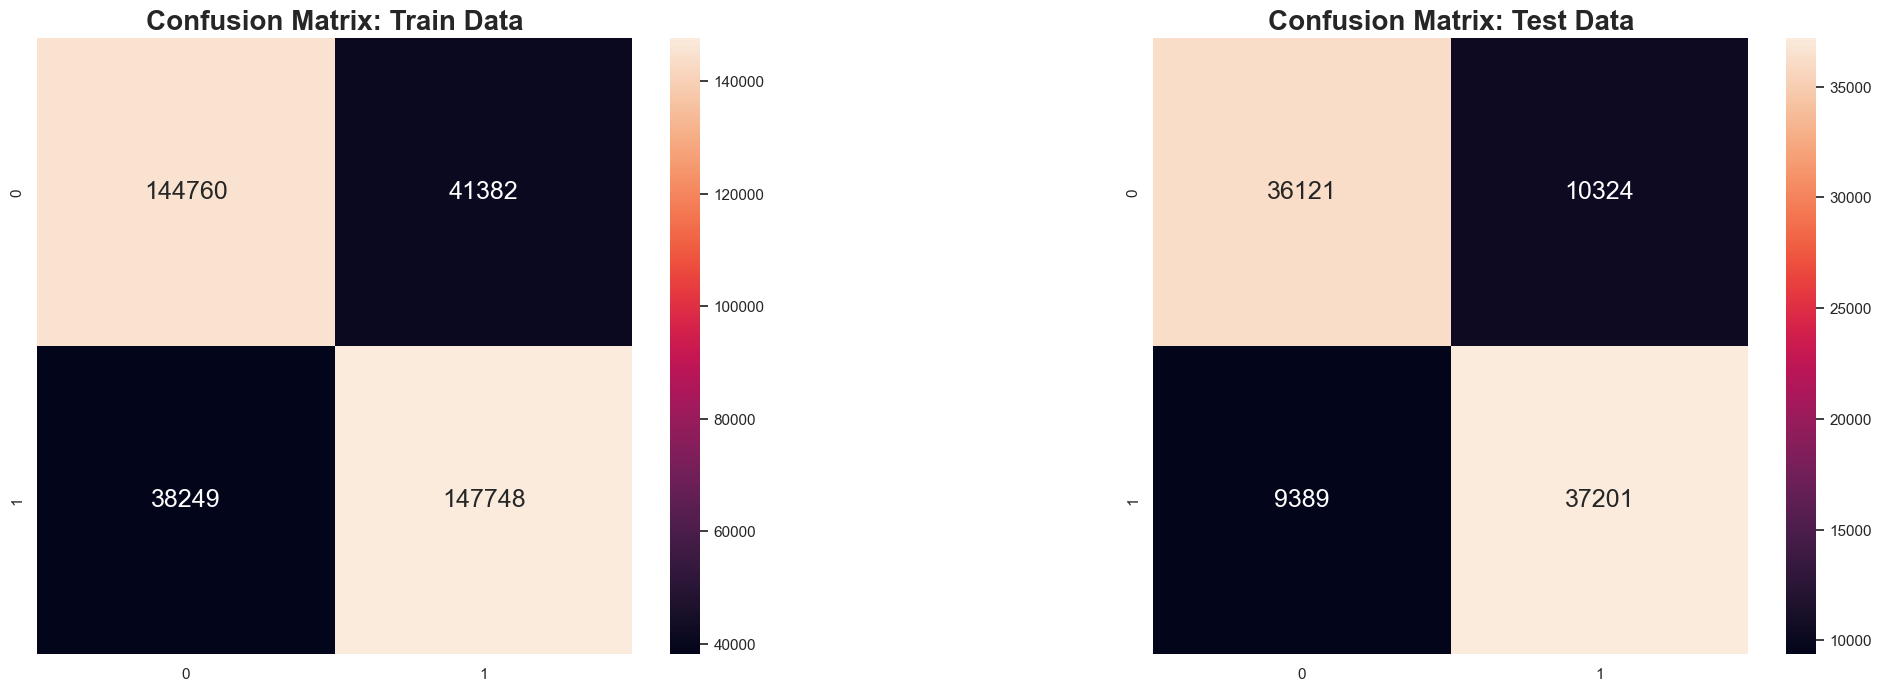

In [190]:
train_model(x_train, x_test, y_train, y_test, DecisionTreeClassifier(max_depth = 5), 5)

# Random Forest

**Reasons for use:**

- (To Do)

/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklea

Train accuracy :  1.0
Train MSE:  0.0 

Test accuracy :  0.9902939753856076
Test MSE:  0.009706024614392433 

Number of folds:  5
Accuracy score (Cross Validated): 0.842465241185533
Standard Deviation (Cross Validated):  0.04255682158760142 

TPR Train :	 1.0
TNR Train :	 1.0
FPR Train :	 0.0
FNR Train :	 0.0 

TPR Test :	 1.0
TNR Test :	 0.9805576488319517
FPR Test :	 0.019442351168048228
FNR Test :	 0.0


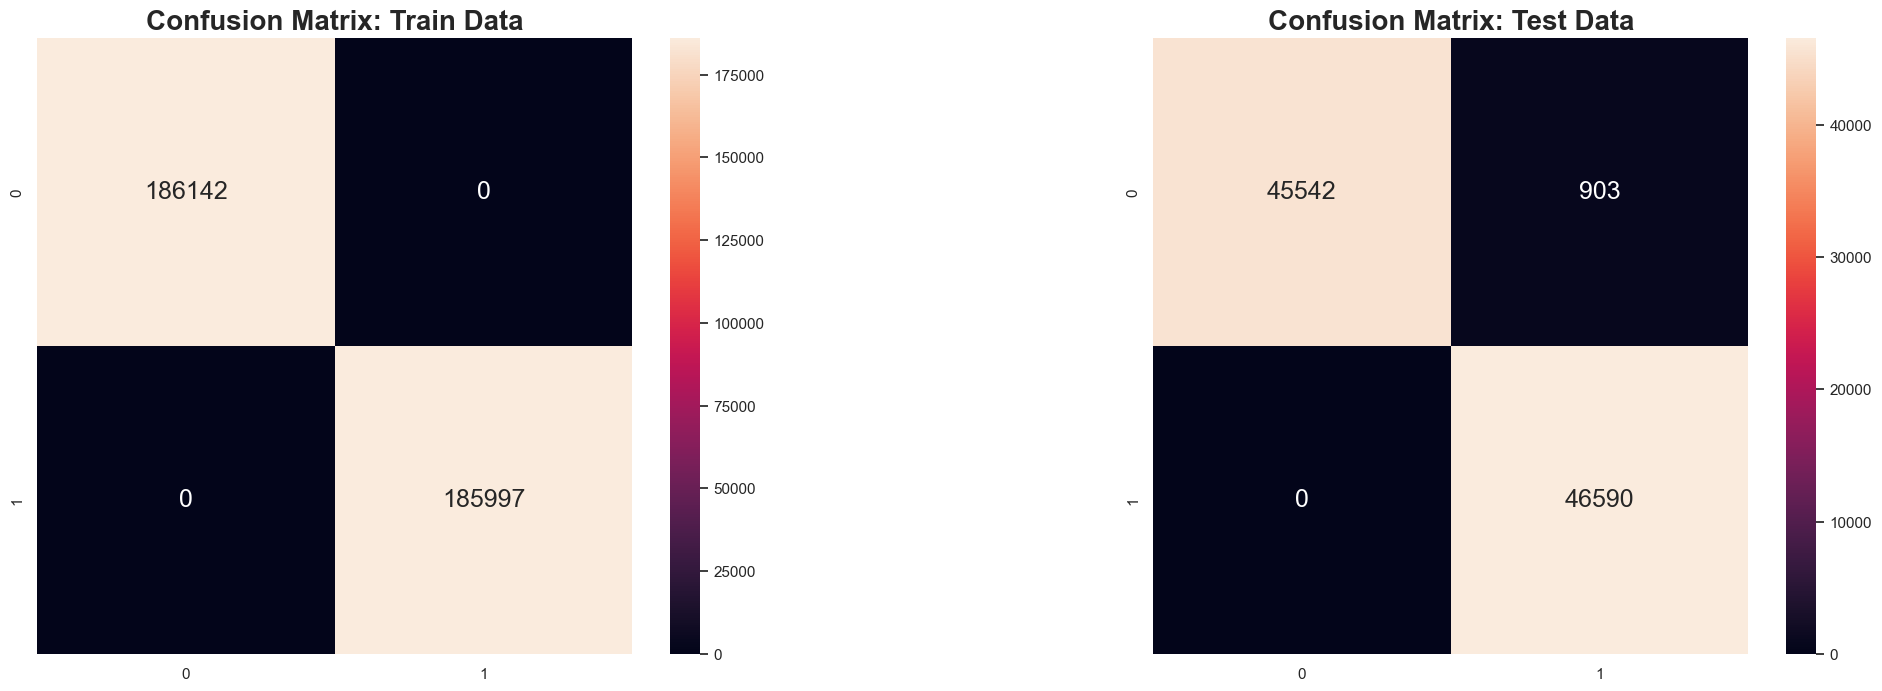

In [191]:
train_model(x_train, x_test, y_train, y_test, RandomForestClassifier(), 5)

# Logistic Regression Model

- (To do)

/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-

Train accuracy :  0.803971096821349
Train MSE:  0.196028903178651 

Test accuracy :  0.805234589133122
Test MSE:  0.19476541086687807 

Number of folds:  None
Accuracy score (Cross Validated): 0.7521077883124213
Standard Deviation (Cross Validated):  0.012114087112964076 

TPR Train :	 0.7665016102410254
TNR Train :	 0.8414113956012077
FPR Train :	 0.15858860439879233
FNR Train :	 0.2334983897589746 

TPR Test :	 0.7697145310152393
TNR Test :	 0.8408655398858865
FPR Test :	 0.15913446011411347
FNR Test :	 0.23028546898476068


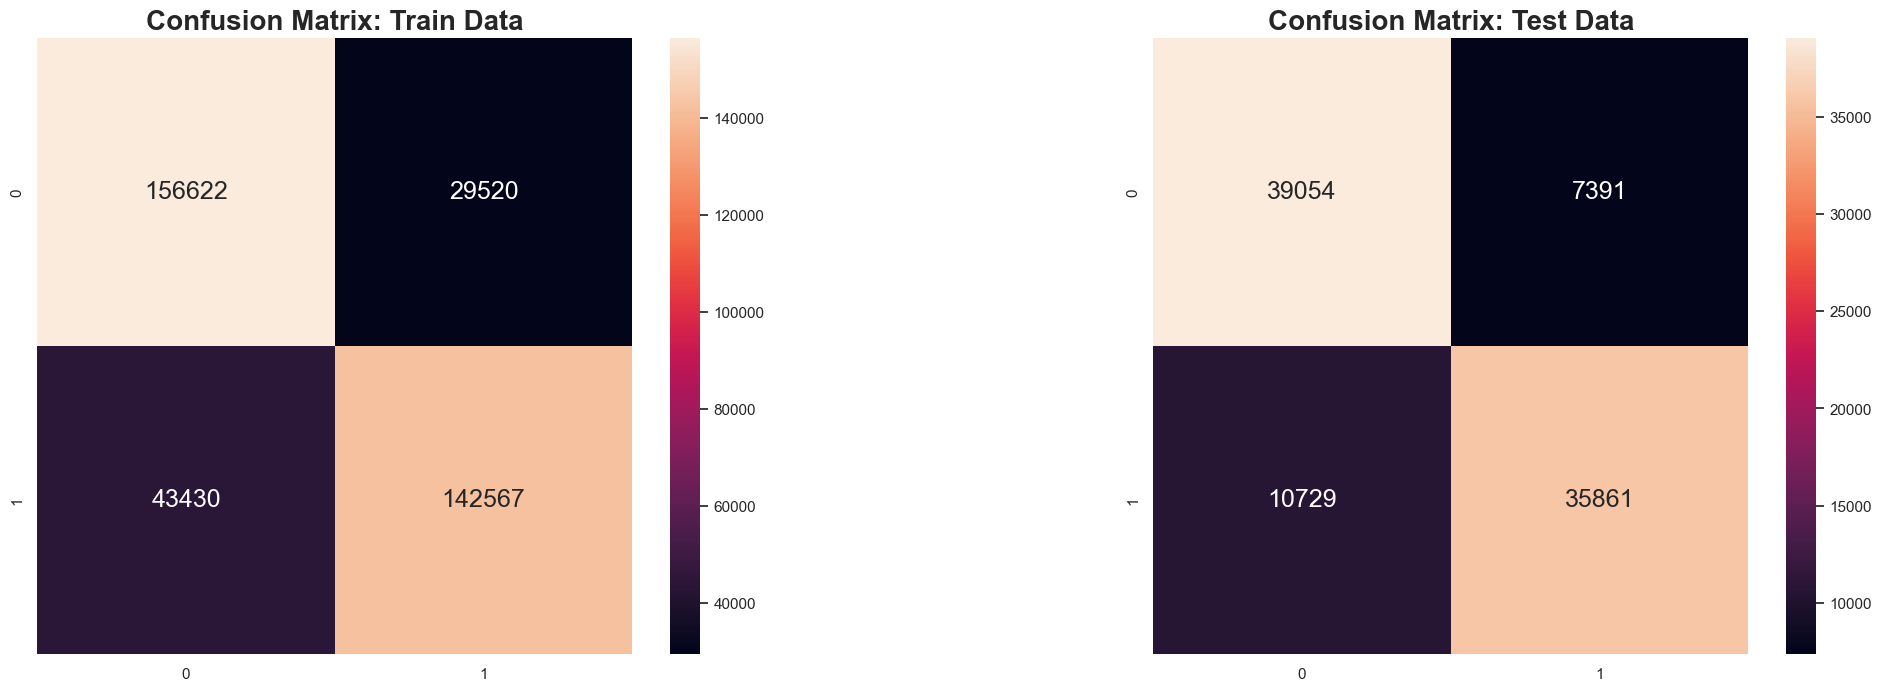

In [192]:
train_model(x_train, x_test, y_train, y_test, LogisticRegression())

# SVC Model

- (To Do)

/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/delta/Things/ntu/y1s2/sc1015/ntu-sc1015-env/lib/python3.12/site-packages/sklearn/uti

Train accuracy :  0.8222925195385188
Train MSE:  0.17770748046148122 

Test accuracy :  0.7759583178265724
Test MSE:  0.22404168217342763 

Number of folds:  None
Accuracy score (Cross Validated): 0.7825828061034612
Standard Deviation (Cross Validated):  0.0020131192164195423 

TPR Train :	 0.8306255835667601
TNR Train :	 0.8140181717040608
FPR Train :	 0.18598182829593918
FNR Train :	 0.16937441643323997 

TPR Test :	 0.7849541284403669
TNR Test :	 0.766704416761042
FPR Test :	 0.2332955832389581
FNR Test :	 0.21504587155963303


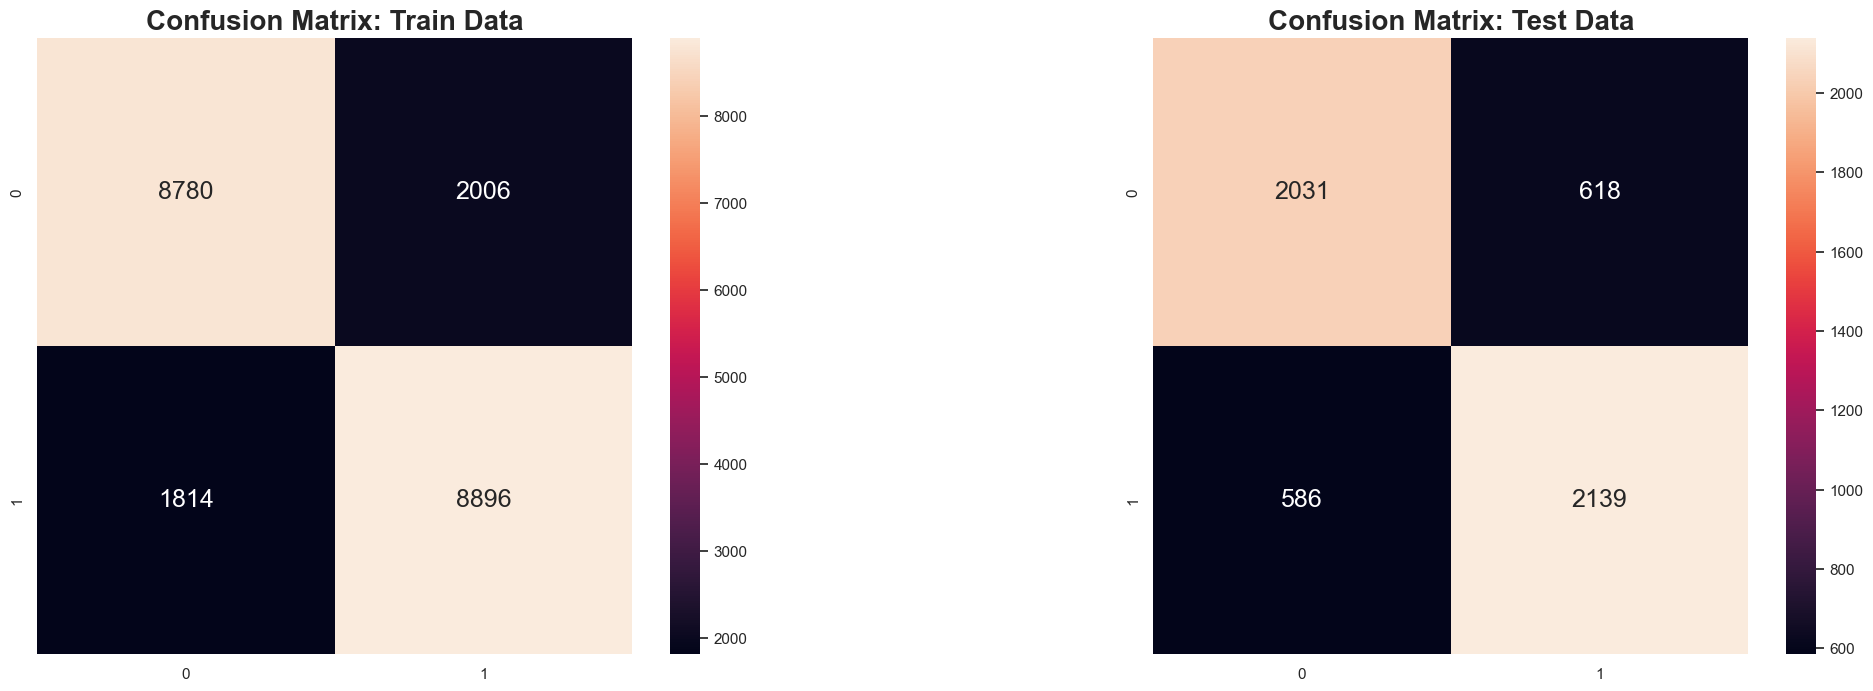

In [38]:
train_model(x_train, x_test, y_train, y_test, SVC(gamma='auto'))

# Fine tuning the model for better results